# Model fitting

Gets us:

- `/data/03_model_inputs/control_prothio.csv`
- `/data/03_model_inputs/control_host.csv`
- `/data/03_model_inputs/input_severities_host.csv`


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Fungicide data

NB `"../data/02_processed/proth_control_raw.csv"` is generated from `src/fitting/fungicide/FungicideControlCurveGenerator.R`.

This converts raw fungicide data (sent via email from Frank I think) to `"../data/02_processed/proth_control_raw.csv"`.

In [20]:
prothio_df = (
    pd.read_csv("../data/02_processed/proth_control_raw.csv")
    .iloc[:, 1:]
    .set_index('year')
    .rename(columns = {
        'RD2': 'asymptote',
        'k2': 'curvature',
        'Srel': 'stb_relative_to_uncontrolled',
        'Control': 'control',
        'minNum': 'min_num',
    })
    .assign(
        untreated_large_sev = 0.37,
        notes = '3 replicates per year - Frank email',
        notes2 = 'untreated_large_sev = Mean disease severity of the 10% largest S0 values - see `Identifying when it is financially beneficial ` paper',
    )
)

prothio_df

,R2,asymptote,curvature,stb_relative_to_uncontrolled,control,number_of_trials,min_num,untreated_large_sev,notes,notes2
year,,,,,,,,,,
2001,0.99,0.760,2.32,0.314688,68.531207,4,12,0.37,3 replicates per year - Frank email,untreated_large_sev = Mean disease severity of...
2002,0.99,0.891,10.29,0.109030,89.096973,1,3,0.37,3 replicates per year - Frank email,untreated_large_sev = Mean disease severity of...
2003,0.99,0.816,3.08,0.221503,77.849725,4,12,0.37,3 replicates per year - Frank email,untreated_large_sev = Mean disease severity of...
2004,0.99,0.757,3.49,0.266089,73.391084,6,18,0.37,3 replicates per year - Frank email,untreated_large_sev = Mean disease severity of...
2005,0.99,0.839,3.02,0.201944,79.805578,6,18,0.37,3 replicates per year - Frank email,untreated_large_sev = Mean disease severity of...
2006,0.99,0.813,4.22,0.198950,80.105000,5,15,0.37,3 replicates per year - Frank email,untreated_large_sev = Mean disease severity of...
2007,0.99,0.900,2.70,0.160485,83.951504,4,12,0.37,3 replicates per year - Frank email,untreated_large_sev = Mean disease severity of...
2008,0.99,0.763,1.54,0.400573,59.942722,6,18,0.37,3 replicates per year - Frank email,untreated_large_sev = Mean disease severity of...
2009,0.99,0.683,2.01,0.408514,59.148574,5,15,0.37,3 replicates per year - Frank email,untreated_large_sev = Mean disease severity of...


## Save fungicide control?

In [21]:
if True:
    filename = "../data/03_model_inputs/control_prothio.csv"
    print(f"saving to {filename}")
    prothio_df.to_csv(filename)

saving to ../data/03_model_inputs/control_prothio.csv


# Host data

From `01_raw/host_trials.csv`, applying `HostCurveGenerator.R` we get:

<!-- - `03_model_inputs/Host/Varieties/FrameFull.csv` -->
<!-- - `03_model_inputs/Host/Varieties/YearlyWorstSevs.csv` -->
<!-- - `03_model_inputs/Host/Varieties/allData.csv` -->

These are the relevant columns from the raw data, considering untreated by fungicide and excluding cultivar mixtures.

We also filter by high pressure locations.

In [4]:
all_data = (
    pd.read_csv('../data/02_processed/Host/allData.csv')
    .iloc[:, 1:]
    # .loc[lambda df: df.location.isin(locations_use.location)]
)

all_data

,year,location,post_code,stb,cultivar
0,1994,Gjern,8883,0.0,Lambros
1,1994,Gjern,8883,0.0,Terra
2,1994,Gjern,8883,0.0,Anthem
3,1994,Gjern,8883,0.0,Lone
4,1994,Gjern,8883,0.0,Athlet
...,...,...,...,...,...
36265,2017,Trige,8380,15.0,Kvarn
36266,2017,Trige,8380,15.0,NaN
36267,2017,Trige,8380,15.0,Elixer
36268,2017,Trige,8380,10.0,NOS509120.16


In [ ]:
if False:
    all_data.to_csv('../data/lise/B.csv', index=False)

Location score greater than or equal to 6

In [6]:
high_pressure_locations = (
    all_data
    .astype({'post_code': 'int64'})
    .set_index('post_code')
    .join(
        pd.read_csv('../data/01_raw/location_scores.csv')
        .replace('<4000', 4000)
        .astype('int64')
        .set_index('postal code')
        .loc[:, ['score_return']]
        .rename(columns={'score_return': 'location_score'})
    )
    .loc[lambda df : df.location_score>=6]
    .drop('location_score', axis=1)
)

high_pressure_locations.head()

,year,location,stb,cultivar
4050,1999,Skibby,14.0,Trintella
4050,1999,Skibby,14.0,Cortez
4050,1999,Skibby,18.0,Ritmo
4050,1999,Skibby,15.0,Pentium
4050,1999,Skibby,16.0,Efal


## Save high pressure locations?

In [17]:
if True:
    high_pressure_locations.to_csv('../data/03_model_inputs/high_pressure_locations.csv', index=False)

In [7]:
cultivars_use = pd.read_csv('../data/04_justification/whichHost/MoreThan8Years.csv').iloc[:, 1:]

cultivars_use

,cultivar,dataPoints,minYear,maxYear,numYears,rSquared,gdt,pVal,yMin,yMax
0,Mariboss,268,2007,2016,10,0.161823,3.140368,7.590000e-12,0.782820,29.046130
1,Hereford,343,2006,2017,12,0.185939,3.382255,5.780000e-17,2.957363,40.162165
2,Jensen,225,2009,2016,8,0.152078,3.227054,1.370000e-09,5.045800,27.635176
3,Tuareg,297,2004,2014,11,0.069665,1.543217,4.000000e-06,6.080012,21.512184
4,Ambition,286,2004,2012,9,0.017882,0.647645,2.371298e-02,6.810825,11.991986
5,JBAsano,248,2005,2015,10,0.064646,1.770700,5.110000e-05,6.831421,24.538425
6,Frument,290,2005,2013,9,0.016456,0.741010,2.895345e-02,9.448894,15.376976
7,KWSDacanto,195,2010,2017,8,0.087944,3.365147,2.560000e-05,10.505028,34.061054


Group data by year, cultivar and location, and get the mean stb score.

Retain the number of data from which this mean was calculated.

In [8]:
mean_by_yr_clt_loc = (
    high_pressure_locations
    .groupby(['year', 'cultivar', 'location'])
    .agg(['mean', 'count'])
    .reset_index()
)

mean_by_yr_clt_loc.columns = mean_by_yr_clt_loc.columns.droplevel(1)
mean_by_yr_clt_loc.columns = list(mean_by_yr_clt_loc.columns)[:-1] + ['count']

mean_by_yr_clt_loc = (
    mean_by_yr_clt_loc
    .sort_values(['cultivar', 'year'])
    .rename(columns={'stb': 'stb_mean'})
    .loc[lambda df: df.stb_mean>0]
)

mean_by_yr_clt_loc

,year,cultivar,location,stb_mean,count
4888,2009,2777GT32,Holeby,4.250000,4
4889,2009,2777GT32,Lystrup,1.500000,4
4890,2009,2777GT32,Oelgod,2.750000,4
2687,2003,798-673C,Oelgod,26.666667,3
2688,2003,798-673C,Toelloese,1.750000,4
...,...,...,...,...,...
3954,2005,Zebedee,Toelloese,4.250000,4
5905,2012,bb850607,Hejnsvig,10.500000,4
5906,2012,bb850607,Holeby,9.000000,4
5907,2012,bb850607,Soenderborg,35.000000,4


Find the worst performing cultivar in each year/location, by mean stb score

In the event of multiple cultivars being equally bad, retain the one with max N data points

If still a clash, arbitrarily select the one first alphabetically

In [9]:
worst_stb_each_loc = (
    mean_by_yr_clt_loc
    .drop(['count', 'cultivar'], axis=1)
    .groupby(['year', 'location'])
    .max()
    .reset_index()
)

worst_stb_with_cult_and_count_non_unique = (
    worst_stb_each_loc
    .set_index(['year', 'location', 'stb_mean'])
    .join(mean_by_yr_clt_loc.set_index(['year', 'location', 'stb_mean']))
    .reset_index()
)

worst_stb_with_cult_and_count = (
    worst_stb_with_cult_and_count_non_unique
    # now pick worst cultivar with highest count (alphabetically sorted in case of a tie)
    # so that have 1 unique worst cultivar per year and location
    .sort_values(['count', 'cultivar'], ascending=[False, True])
    .groupby(['year', 'location'])
    .first()
    .reset_index()
)

worst_stb_with_cult_and_count

,year,location,stb_mean,cultivar,count
0,1996,Karise,18.000,Rialto,5
1,1996,Kerteminde,14.000,Rialto,5
2,1996,Loegstoer,0.100,Hussar,5
3,1996,Naestved,18.400,Rialto,5
4,1996,Nykoebing,48.000,Rialto,5
...,...,...,...,...,...
315,2016,Trige,0.635,KWSCleveland,4
316,2017,Holeby,11.250,Output,4
317,2017,Ringsted,31.750,KWSCleveland,4
318,2017,Soenderborg,93.750,KWSCleveland,4


## Save worst stb cult and count (non unique)?

In [10]:
if True:
    worst_stb_with_cult_and_count_non_unique.to_csv('../data/03_model_inputs/worst_stb_with_cult_and_count_non_unique.csv', index=False)

Combine so that we have dataframe with, for each year and location:
- stb scores from cultivars we care about
- stb scores from worst cultivar
- names of both
- number of data for both
- control offered
- minimum of number of data for cultivar vs worst cultivar


<i>We could filter out any year/location combos where the worst cultivar had a mean severity lower than 5.</i>

<i>This is because dividing by small numbers causes greater variation, and we are most interested in situations where fungicide control would be required i.e. higher disease pressure - CHOOSING NOT TO, UNNECESSARY COMPLICATION</i>



In [11]:
control_df = (
    mean_by_yr_clt_loc
    .set_index(['year', 'location'])
    .join(
        worst_stb_with_cult_and_count
        .set_index(['year', 'location']),
        rsuffix='_worst'
    )
    .reset_index()
    
    .loc[lambda df: df.cultivar.isin(cultivars_use.cultivar)]
    .assign(
        control = lambda df: 100 * (df.stb_mean_worst - df.stb_mean) / df.stb_mean_worst,
        min_num = lambda df: df.loc[:, ['count', 'count_worst']].min(axis=1)
    )
    
    .sort_values(['cultivar', 'year', 'location'])
    # .loc[lambda df: df.stb_mean_worst>=5]
)

control_df

,year,location,cultivar,stb_mean,count,stb_mean_worst,cultivar_worst,count_worst,control,min_num
3067,2004,Holeby,Ambition,0.20,4,0.725,Biscay,4,72.413793,4
3322,2004,Toelloese,Ambition,2.00,4,8.000,Biscay,4,75.000000,4
3392,2004,Trige,Ambition,4.00,4,30.000,SWGnejs,4,86.666667,4
3481,2005,Grindsted,Ambition,9.50,4,33.750,Bravur,4,71.851852,4
3562,2005,Hinnerup,Ambition,0.35,4,4.000,Bravur,4,91.250000,4
...,...,...,...,...,...,...,...,...,...,...
6194,2014,Karise,Tuareg,40.00,4,58.750,KWSCleveland,4,31.914894,4
6207,2014,Maribo,Tuareg,50.00,8,82.500,JBAsano,4,39.393939,4
6226,2014,Ringsted,Tuareg,13.00,4,21.750,KWSCleveland,4,40.229885,4
6265,2014,Soenderborg,Tuareg,72.50,4,95.000,NOS15098.01,4,23.684211,4


<AxesSubplot:xlabel='year', ylabel='control'>

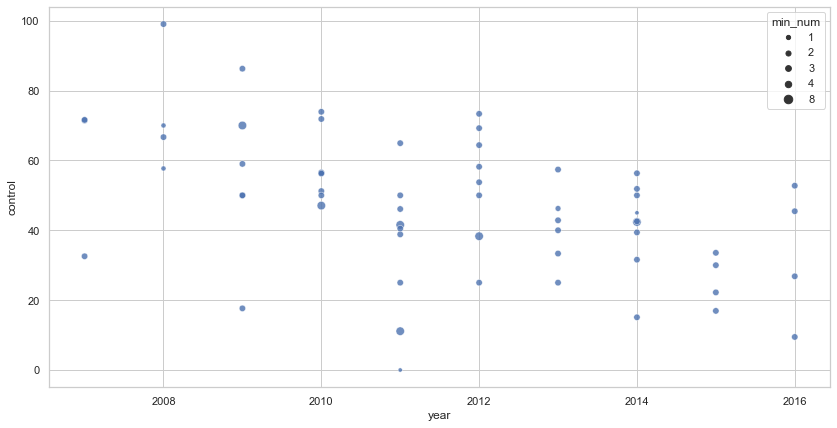

In [12]:
f, ax = plt.subplots(figsize=(14,7))

sns.scatterplot(
    x='year', 
    y='control',
    size='min_num', 
    data=control_df.loc[control_df.cultivar=='Mariboss'],
    alpha=0.8,
)

## Save host control?

These are the control values for each interesting host variety for model fitting

In [13]:
if False:
    filename = '../data/03_model_inputs/control_host.csv'
    print(f"saving to {filename}")
    control_df.to_csv(filename)

control_df.head(5)

,year,location,cultivar,stb_mean,count,stb_mean_worst,cultivar_worst,count_worst,control,min_num
3067,2004,Holeby,Ambition,0.20,4,0.725,Biscay,4,72.413793,4
3322,2004,Toelloese,Ambition,2.00,4,8.000,Biscay,4,75.000000,4
3392,2004,Trige,Ambition,4.00,4,30.000,SWGnejs,4,86.666667,4
3481,2005,Grindsted,Ambition,9.50,4,33.750,Bravur,4,71.851852,4
3562,2005,Hinnerup,Ambition,0.35,4,4.000,Bravur,4,91.250000,4


## Save worst stb?

These are the severities to use as inputs into the host model fitting for each year, corresponding to the mean worst stb, by host and year

In [14]:
mean_worst_severities = (
    control_df
    .loc[:, ['year',
             'location',
             'cultivar',
             'count_worst',
             'stb_mean_worst',
    ]]
    
    .assign(scaled_worst = lambda df: df.count_worst * df.stb_mean_worst)
    
    .drop('stb_mean_worst', axis=1)
    
    .groupby(['year', 'cultivar'])
    
    .sum()
    
    .assign(worst_stb = lambda df: df.scaled_worst / df.count_worst)
    
    .loc[:, ['worst_stb']]
    .reset_index()
    
    .sort_values(['cultivar', 'year'])
    
    .reset_index(drop=True)
    
)

mean_worst_severities

,year,cultivar,worst_stb
0,2004,Ambition,12.908333
1,2005,Ambition,29.571429
2,2006,Ambition,35.694444
3,2007,Ambition,26.964286
4,2008,Ambition,5.056176
...,...,...,...
72,2010,Tuareg,14.875000
73,2011,Tuareg,22.032500
74,2012,Tuareg,35.333333
75,2013,Tuareg,29.708333


(0.0, 50.0)

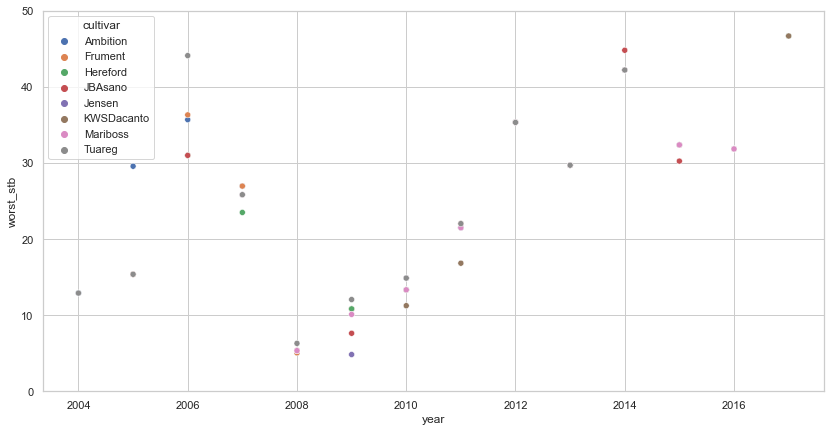

In [15]:
f, ax = plt.subplots(figsize=(14,7))

sns.scatterplot(x='year', y='worst_stb', hue='cultivar', data=mean_worst_severities, ax=ax)

ax.set_ylim([0,50])

In [16]:
if False:
    filename = '../data/03_model_inputs/input_severities_host.csv'
    print(f"saving to {filename}")
    mean_worst_severities.to_csv(filename)

mean_worst_severities.head(5)

,year,cultivar,worst_stb
0,2004,Ambition,12.908333
1,2005,Ambition,29.571429
2,2006,Ambition,35.694444
3,2007,Ambition,26.964286
4,2008,Ambition,5.056176
